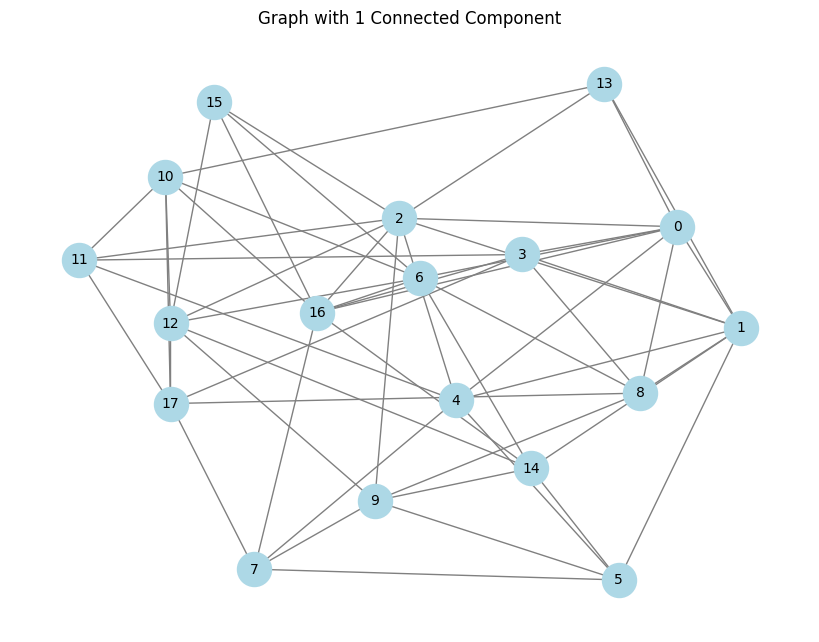

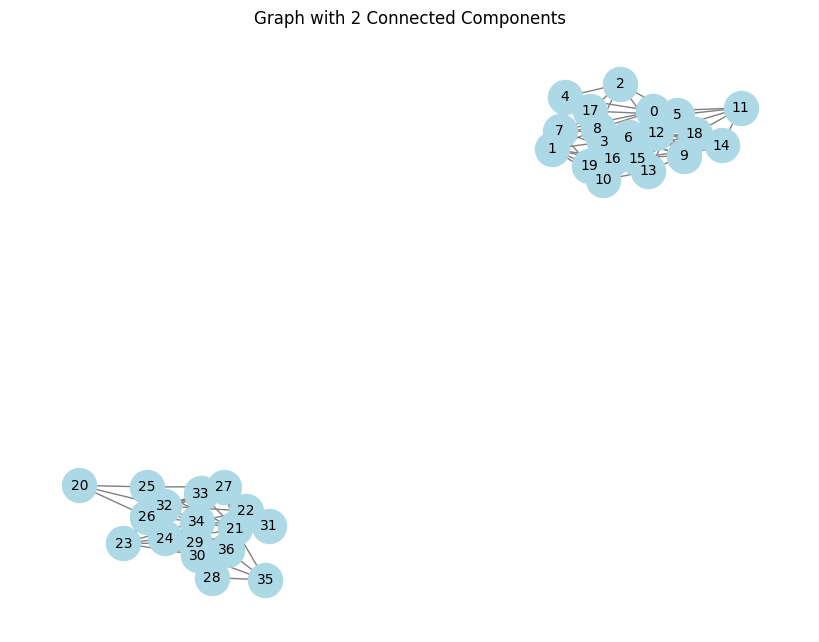

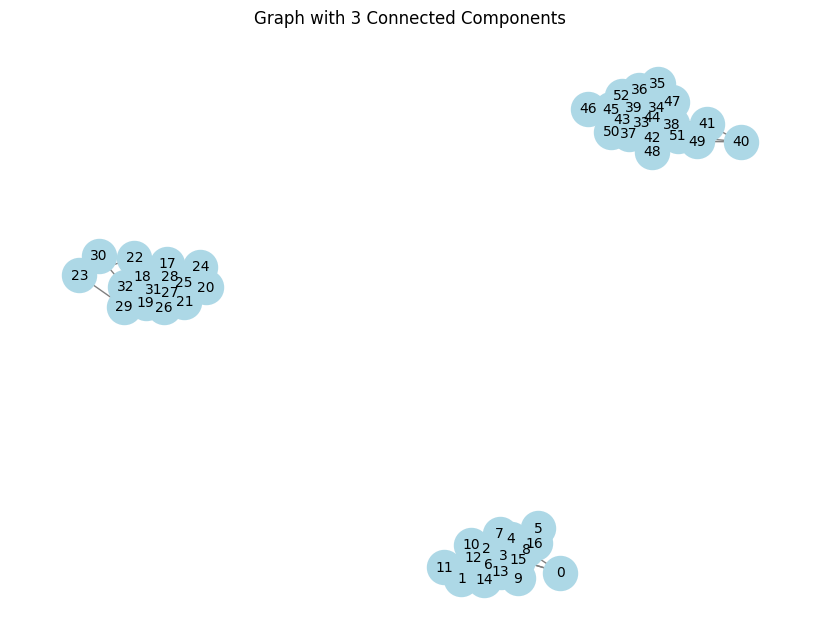

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Function to create a graph with a specific number of connected components
def create_graph_with_components(num_components, min, max):
    G = nx.Graph()
    for i in range(num_components):
        # Create a random number of nodes for the component
        num_nodes = random.randint(min, max)
        # Create a random connected component
        component = nx.erdos_renyi_graph(n=num_nodes, p=0.4)
        while not nx.is_connected(component):
            component = nx.erdos_renyi_graph(n=num_nodes, p=0.4)
        # Relabel nodes to avoid overlaps
        mapping = {node: node + len(G) for node in component.nodes}
        component = nx.relabel_nodes(component, mapping)
        # Add the component to the main graph
        G = nx.compose(G, component)
    return G

# Visualization function
def plot_graph(G, title):
    plt.figure(figsize=(8, 6))
    nx.draw_spring(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=600, font_size=10)
    plt.title(title)
    plt.show()

# Create example graphs
graph1 = create_graph_with_components(1,15,20)  # 1 connected component
graph2 = create_graph_with_components(2,15,20)  # 2 connected components
graph3 = create_graph_with_components(3,15,20)  # 3 connected components

# Plot the graphs
plot_graph(graph1, "Graph with 1 Connected Component")
plot_graph(graph2, "Graph with 2 Connected Components")
plot_graph(graph3, "Graph with 3 Connected Components")


In [ ]:
#Graphs with 15-20 nodes
graphs = []
for i in range(5000):
  graphs.append(create_graph_with_components(1,15,20))
for i in range(5000):
  graphs.append(create_graph_with_components(2,15,20))
for i in range(5000):
  graphs.append(create_graph_with_components(3,15,20))
# temp = []
# for i in range(500):
#   index = random.randint(0, (len(graphs) / 3))
#   temp.append(graphs[index])
#   temp.append(graphs[index + 5000])
#   temp.append(graphs[index + 10000])
# graphs = temp
#random.shuffle(graphs)

#Graphs with 40-50 nodes
# graphs = []
# for i in range(5000):
#   graphs.append(create_graph_with_components(1,40,50))
# for i in range(5000):
#   graphs.append(create_graph_with_components(2,40,50))
# for i in range(5000):
#   graphs.append(create_graph_with_components(3,40,50))

#Graphs with 90-100 nodes
# graphs = []
# for i in range(5000):
#   graphs.append(create_graph_with_components(1,90,100))
# for i in range(5000):
#   graphs.append(create_graph_with_components(2,90,100))
# for i in range(5000):
#   graphs.append(create_graph_with_components(3,90,100))


In [ ]:
#Counts the number of connected components in a graph using BFS, used to find our gold classifier
def bfs_count_components(adj_list):
    visited = set()  # Track visited nodes
    num_components = 0

    def bfs(start_node):
        queue = [start_node]
        while queue:
            node = queue.pop(0)
            if node not in visited:
                visited.add(node)
                queue.extend(neighbor for neighbor in adj_list[node] if neighbor not in visited)

    for node in adj_list:
        if node not in visited:
            num_components += 1
            bfs(node)

    return num_components

import networkx as nx

# Extract adjacency matrix from custom graph object
adj_matrix = nx.to_numpy_array(graphs[0])  # Returns the adjacency matrix as a NumPy array

# Convert adjacency matrix to adjacency list
def adj_matrix_to_list(adj_matrix):
    adj_list = {i: [] for i in range(len(adj_matrix))}
    for i in range(len(adj_matrix)):
        for j in range(len(adj_matrix[i])):
            if adj_matrix[i][j] == 1:  # Check if there's an edge
                adj_list[i].append(j)
    return adj_list

adj_list = adj_matrix_to_list(adj_matrix)

# Use the BFS function to count the number of connected components
num_components = bfs_count_components(adj_list)
print(f"Number of connected components: {num_components}")



Number of connected components: 1


In [ ]:
graph_comp = []
for i in range(len(graphs)):
  adj_matrix = nx.to_numpy_array(graphs[i])  # Returns the adjacency matrix as a NumPy array
  adj_list = adj_matrix_to_list(adj_matrix)
  num_components = bfs_count_components(adj_list)
  graph_comp.append(num_components)

In [ ]:
!pip install -q torch-geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import torch_geometric.nn as pyg_nn

class Structure2Vec(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, hidden_channels)
        self.conv2 = pyg_nn.GCNConv(hidden_channels, hidden_channels)
        self.global_pool = pyg_nn.global_mean_pool  # Use mean pooling for graph-level representation
        self.fc = nn.Linear(hidden_channels, num_classes)  # Class logits

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        graph_embedding = self.global_pool(x, batch)  # Aggregate node embeddings
        return self.fc(graph_embedding)  # Return class logits

    def message(self, x_j):
        """
        Defines the message function.
        :param x_j: Neighbor node features.
        :return: Transformed features.
        """
        return self.mlp(x_j)

    def update(self, aggr_out):
        """
        Update node features after aggregation.
        :param aggr_out: Aggregated features.
        :return: Updated node embeddings.
        """
        return self.out_proj(aggr_out)


In [ ]:
#import torch_geometric.transforms as T
from torch_geometric.utils import from_networkx
datas = []
for i in range(len(graphs)):
  label = graph_comp[i]
  data = from_networkx(graphs[i])
  data.x = torch.ones(data.num_nodes, 1)  # Set all node features to 1
  data.y = torch.tensor([label], dtype=torch.long)
  datas.append(data)

In [ ]:
from torch_geometric.loader import DataLoader

# Create a DataLoader for batching
#random.shuffle(datas)
train_loader = DataLoader(datas[:90], batch_size=32, shuffle=True)
test_loader = DataLoader(datas[10:], batch_size=32, shuffle=False)

# Initialize the Structure2Vec model
model = Structure2Vec(in_channels=datas[0].num_features, hidden_channels=32, num_classes=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(100):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        embedding = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(embedding, batch.y)  # Batch labels
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")


Epoch 1, Loss: 3.2930
Epoch 2, Loss: 3.1941
Epoch 3, Loss: 3.0977
Epoch 4, Loss: 3.0046
Epoch 5, Loss: 2.9130
Epoch 6, Loss: 2.8232
Epoch 7, Loss: 2.7348
Epoch 8, Loss: 2.6448
Epoch 9, Loss: 2.5523
Epoch 10, Loss: 2.4566
Epoch 11, Loss: 2.3574
Epoch 12, Loss: 2.2544
Epoch 13, Loss: 2.1479
Epoch 14, Loss: 2.0378
Epoch 15, Loss: 1.9248
Epoch 16, Loss: 1.8090
Epoch 17, Loss: 1.6912
Epoch 18, Loss: 1.5718
Epoch 19, Loss: 1.4525
Epoch 20, Loss: 1.3345
Epoch 21, Loss: 1.2194
Epoch 22, Loss: 1.1080
Epoch 23, Loss: 1.0010
Epoch 24, Loss: 0.8999
Epoch 25, Loss: 0.8048
Epoch 26, Loss: 0.7171
Epoch 27, Loss: 0.6369
Epoch 28, Loss: 0.5644
Epoch 29, Loss: 0.4994
Epoch 30, Loss: 0.4418
Epoch 31, Loss: 0.3909
Epoch 32, Loss: 0.3463
Epoch 33, Loss: 0.3075
Epoch 34, Loss: 0.2737
Epoch 35, Loss: 0.2444
Epoch 36, Loss: 0.2190
Epoch 37, Loss: 0.1970
Epoch 38, Loss: 0.1778
Epoch 39, Loss: 0.1609
Epoch 40, Loss: 0.1458
Epoch 41, Loss: 0.1324
Epoch 42, Loss: 0.1205
Epoch 43, Loss: 0.1100
Epoch 44, Loss: 0.10

In [ ]:
def attack_graph(data, model, num_edges_to_add=1, num_edges_to_remove=1):
    """
    Modify the graph to perform an attack.
    :param data: PyTorch Geometric Data object.
    :param model: Trained Structure2Vec model.
    :param num_edges_to_add: Number of edges to add.
    :param num_edges_to_remove: Number of edges to remove.
    :return: Modified graph data.
    """
    model.eval()
    with torch.no_grad():
        # Create the batch attribute if not present
        if not hasattr(data, 'batch'):
            data.batch = torch.zeros(data.num_nodes, dtype=torch.long)

        # Original prediction
        original_prediction = model(data.x, data.edge_index, data.batch)
        print(f"Original Prediction: {original_prediction.argmax(dim=1)}")

    # Modify the graph by adding/removing edges
    edge_index = data.edge_index.clone()

    # Remove random edges
    if num_edges_to_remove > 0:
        edge_index = edge_index[:, :-num_edges_to_remove]

    # Add random edges
    if num_edges_to_add > 0:
        num_nodes = data.x.size(0)
        new_edges = torch.randint(0, num_nodes, (2, num_edges_to_add))
        edge_index = torch.cat([edge_index, new_edges], dim=1)

    # Update the graph
    data.edge_index = edge_index

    # Evaluate the modified graph
    with torch.no_grad():
        modified_prediction = model(data.x, data.edge_index, data.batch)
        print(f"Modified Prediction: {modified_prediction.argmax(dim=1)}")

    return data


In [ ]:
def evaluate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            output = model(batch.x, batch.edge_index, batch.batch)
            predictions = output.argmax(dim=1)
            correct += (predictions == batch.y).sum().item()
            total += batch.y.size(0)
    return correct / total


In [ ]:
# Evaluate accuracy before the attack
original_accuracy = evaluate_accuracy(test_loader, model)
print(f"Original Accuracy: {original_accuracy:.2f}")

# # Modify graphs (e.g., via attack_graph)
# modifiedg = attack_graph(testg, model, num_edges_to_add=500, num_edges_to_remove=3000)

# # Evaluate accuracy after the attack
# with torch.no_grad():
#     modified_prediction = model(modifiedg.x, modifiedg.edge_index, modifiedg.batch).argmax(dim=1)
#     is_correct = (modified_prediction == modifiedg.y).item()  # Check if prediction matches label
#     print(f"Modified Prediction Correct: {is_correct}")


Original Accuracy: 0.33


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -q spektral
import spektral
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
#spektral.data.Graph(a,x,e,y)
# a: adjacency matrix (Store as Scipy sparse matrix)
# x: node features (Store as dense array)
# e: edge features -------NOT USED
# y: labels (Node-level data labels will most likely be of type 2-dimensional array of shape [n_nodes, n_labels])

#spektral.data.Dataset (Maybe contains our datasets)

# Might use to apply our GCN filter for preprocessing of data
# from spektral.transforms import GCNFilter
# dataset.apply(GCNFilter())

# Simple GNN network class
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from spektral.layers import GCNConv, GlobalSumPool
from spektral.utils import sp_matrix_to_sp_tensor
from spektral.datasets import Citation
from spektral.data import SingleLoader

class MyFirstGNN(Model):

    def __init__(self, n_hidden, n_labels):
        super().__init__()
        self.graph_conv = GCNConv(n_hidden)
        self.pool = GlobalSumPool()
        self.dropout = Dropout(0.5)
        self.dense = Dense(n_labels, 'softmax')

    def call(self, inputs):
        out = self.graph_conv(inputs)
        out = self.dropout(out)
        out = self.pool(out)
        out = self.dense(out)

        return out
dataset = []
for i in range(1500)
  max_n = 50 #Alts 20, 50, 100
  min_n = 40 #Alts 15, 40, 90
  p = 0.02
  cur_n = np.random.randint(max_n - min_n + 1) + min_n
  dataset.append(nx.erdos_renyi_graph(cur_n,p))
#print(dataset)

Graph with 47 nodes and 28 edges


In [ ]:
!pip install -q torch-geometric
import torch
import random
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GATConv

dataset = Planetoid(root='data/Planetoid', name='Citeseer', transform=NormalizeFeatures())
#dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
#dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())

print('======================')
print(f'Dataset: {dataset}')
print(f'Data type:')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('======================')

data = dataset[0]  # Get the first graph object.
print("Data type of data graph object: ")
print(type(data))
print(data)

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        #torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def train(datain):
      model.train()
      optimizer.zero_grad()
      out = model(data.x, datain.edge_index)
      loss = criterion(out[datain.train_mask], datain.y[datain.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(datain):
      model.eval()
      out = model(data.x, datain.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[datain.test_mask] == datain.y[datain.test_mask]
      test_acc = int(test_correct.sum()) / int(datain.test_mask.sum())
      return test_acc

model = GCN(hidden_channels=16)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 101):
    loss = train(data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test(data)
print(f'Test Accuracy: {test_acc:.4f}')



Dataset: Citeseer()
Data type:
Number of graphs: 1
Number of features: 3703
Number of classes: 6
Data type of data graph object: 
<class 'torch_geometric.data.data.Data'>
Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
GCN(
  (conv1): GCNConv(3703, 16)
  (conv2): GCNConv(16, 6)
)
Epoch: 001, Loss: 1.7913
Epoch: 002, Loss: 1.7863
Epoch: 003, Loss: 1.7789
Epoch: 004, Loss: 1.7700
Epoch: 005, Loss: 1.7583
Epoch: 006, Loss: 1.7471
Epoch: 007, Loss: 1.7383
Epoch: 008, Loss: 1.7280
Epoch: 009, Loss: 1.7156
Epoch: 010, Loss: 1.7049
Epoch: 011, Loss: 1.6930
Epoch: 012, Loss: 1.6795
Epoch: 013, Loss: 1.6696
Epoch: 014, Loss: 1.6449
Epoch: 015, Loss: 1.6326
Epoch: 016, Loss: 1.6191
Epoch: 017, Loss: 1.6042
Epoch: 018, Loss: 1.5825
Epoch: 019, Loss: 1.5824
Epoch: 020, Loss: 1.5593
Epoch: 021, Loss: 1.5658
Epoch: 022, Loss: 1.5315
Epoch: 023, Loss: 1.5331
Epoch: 024, Loss: 1.5032
Epoch: 025, Loss: 1.4827
Epoch: 026, Loss: 1.5003
Epoch: 027

In [ ]:
!pip install -q torch-geometric
import torch
import math
import random
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GATConv

dataset = Planetoid(root='data/Planetoid', name='Citeseer', transform=NormalizeFeatures())
#dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
#dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())

print('======================')
print(f'Dataset: {dataset}')
print(f'Data type:')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('======================')

data = dataset[0]  # Get the first graph object.
print("Data type of data graph object: ")
print(type(data))
print(data)

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc

def randSamp(inputData, nodes_attacked):
    dataSample = inputData.clone()
    hitlist = []

    # Get results before modification
    model.eval()
    ouch = model(dataSample.x, dataSample.edge_index)
    ogPredictions = ouch.argmax(dim=1)

    # Take random nodes and add to hitlist
    i = 0
    while i < nodes_attacked:
        candidate = random.randint(0, dataSample.num_nodes - 1)
        if candidate not in hitlist and (ogPredictions[candidate] == dataSample.y[candidate]):
            hitlist.append(candidate)
            i += 1
    # hitlist.append(math.floor(len(data.x)/2))
    # print(hitlist)

    stopping = 0
    constraint = False
    target_down = False
    backupData = dataSample.clone()
    addBackupData = dataSample.clone()
    # First, try subtracting edges from graph to satisfy constraints
    while not (len(hitlist) == 0):
        # Remove random edge connected to hitlist nodes
        dataSample = remove_random_edge(dataSample, hitlist)
        if(dataSample == None):
            dataSample = addBackupData.clone()
            break

        # Get new results
        model.eval()
        ywouch = model(dataSample.x, dataSample.edge_index)
        newPredictions = ywouch.argmax(dim=1)

        # Check different
        if(isDifferent(ogPredictions, newPredictions)):
          print("Different")

        # Check constraints
        constraint = constraintSatisfaction(ogPredictions, newPredictions, hitlist)
        target_down = targetDown(ogPredictions, newPredictions, hitlist)

        # If constraints not met, restore backup
        # if not constraint:
        #     dataSample = backupData.clone()
        #     stopping -= 1
        # else:
        #     backupData = dataSample.clone()
        #     stopping += 1
        hitlist = newHitList(ogPredictions, newPredictions, hitlist)
    # If subtracting edges doesn't work, try additing edges
    while not (constraint and target_down):
        # Add random edge connected to hitlist nodes
        dataSample = add_random_edge(dataSample, hitlist)
        if(dataSample == None):
            dataSample = addBackupData.clone()
            break

        # Get new results
        model.eval()
        ywouch = model(dataSample.x, dataSample.edge_index)
        newPredictions = ywouch.argmax(dim=1)

        # Check different
        if(isDifferent(ogPredictions, newPredictions)):
          print("Different")

        # Check constraints
        constraint = constraintSatisfaction(ogPredictions, newPredictions, hitlist)
        target_down = targetDown(ogPredictions, newPredictions, hitlist)

        # If constraints not met, restore backup
        if not constraint:
            dataSample = backupData.clone()
            stopping -= 1
        else:
            backupData = dataSample.clone()
            stopping += 1

    return dataSample

def isDifferent(og, new):
  for i in range(len(og)):
    if og[i] != new[i]:
      return True
  return False

def add_random_edge(data, hitlist):
    # Get candidate nodes for edge addition
    candidate_nodes = []
    #find the neighbors of the hitlist nodes
    for i in hitlist:
        for j in range(data.edge_index.shape[1]):
            if data.edge_index[0][j] == i:
                #add index of the neighbor to the candidate nodes
                candidate_nodes.append(data.edge_index[1][j])
            elif data.edge_index[1][j] == i:
                candidate_nodes.append(data.edge_index[0][j])
    # Remove duplicates
    candidate_nodes = list(set(candidate_nodes))

    # Select random node to add edge
    node_to_add_edge = candidate_nodes[random.randint(0, len(candidate_nodes) - 1)]

    # Add edge between the node and a random neighbor
    # Get all neighbors of the node
    neighbors = []
    for i in range(data.edge_index.shape[1]):
        if data.edge_index[0][i] == node_to_add_edge:
            neighbors.append(data.edge_index[1][i])
        elif data.edge_index[1][i] == node_to_add_edge:
            neighbors.append(data.edge_index[0][i])

    # Select random neighbor
    neighbor_to_add_edge = neighbors[random.randint(0, len(neighbors) - 1)]

    # Add the edge
    new_edge = torch.tensor([[node_to_add_edge, neighbor_to_add_edge],
                              [neighbor_to_add_edge, node_to_add_edge]], dtype=torch.long)
    data.edge_index = torch.cat([data.edge_index, new_edge], dim=1)

    return data

def remove_random_edge(data, hitlist):
    # Get candidate nodes for edge removal
    candidate_nodes = []
    #find the neighbors of the hitlist nodes
    for i in hitlist:
        for j in range(data.edge_index.shape[1]):
            if data.edge_index[0][j] == i:
                #add index of the neighbor to the candidate nodes
                candidate_nodes.append(data.edge_index[1][j])
            elif data.edge_index[1][j] == i:
                candidate_nodes.append(data.edge_index[0][j])
    # Remove duplicates
    candidate_nodes = list(set(candidate_nodes))

    # Create list of every edge connected to the candidate nodes
    candidate_edges = []
    for i in candidate_nodes:
        for j in range(data.edge_index.shape[1]):
            if data.edge_index[0][j] == i:
                candidate_edges.append(j)
            elif data.edge_index[1][j] == i:
                candidate_edges.append(j)

    # Remove duplicates
    candidate_edges = list(set(candidate_edges))
    print(candidate_edges)
    if len(candidate_edges) == 0:
        return None

    # Select random edge to remove
    edge_to_remove = candidate_edges[random.randint(0, len(candidate_edges) - 1)]

    # Remove the edge
    # Create a mask to select all edges except the one to remove
    num_edges = data.edge_index.shape[1]
    mask = torch.ones(num_edges, dtype=torch.bool)
    mask[edge_to_remove] = False

    # Update edge_index with the remaining edges
    data.edge_index = data.edge_index[:, mask]

    return data

def constraintSatisfaction(ogPredictions, newPredictions, hitlist):
  for i in range(len(ogPredictions)):
    if i not in hitlist and (ogPredictions[i] != newPredictions[i]):
      return False
  return True

def targetDown(ogPredictions, newPredictions, hitlist):
  for i in range(len(hitlist)):
    if ogPredictions[hitlist[i]] == newPredictions[hitlist[i]]:
      return False
  return True

def newHitList(ogPredictions, newPredictions, hitlist):
  newHitlist = []
  for i in range(len(hitlist)):
    if ogPredictions[hitlist[i]] == newPredictions[hitlist[i]]:
      newHitlist.append(hitlist[i])
  return newHitlist

model = GCN(hidden_channels=16)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 101):
    loss = train()
    #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
data = randSamp(data, 1)

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')


Dataset: Citeseer()
Data type:
Number of graphs: 1
Number of features: 3703
Number of classes: 6
Data type of data graph object: 
<class 'torch_geometric.data.data.Data'>
Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
GCN(
  (conv1): GCNConv(3703, 16)
  (conv2): GCNConv(16, 6)
)
[3, 4116, 26, 6192, 6198, 4155, 8251, 8254, 4173, 4174, 99, 100, 101, 102, 4212, 8309, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 180, 8378, 2237, 8387, 6364, 6366, 4327, 4339, 460, 2349, 2351, 4407, 4408, 4409, 4410, 4411, 4412, 4413, 4414, 4415, 4416, 6477, 4546, 346, 4458, 2417, 2418, 2419, 2420, 2421, 2422, 4474, 4475, 4476, 4553, 393, 394, 397, 4558, 410, 2462, 429, 4533, 4534, 4535, 4536, 2489, 4538, 4539, 4540, 4541, 4537, 4542, 4543, 4545, 450, 4547, 4548, 4549, 4550, 4551, 4552, 4544, 4554, 4555, 4556, 8652, 461, 4559, 4560, 4561, 4557, 467, 468, 469, 470, 471, 6610, 4571, 6620, 6622, 485, 496, 6646, 6652, 6657, 6660, 534, 535, 4647, 46

In [ ]:
!pip install -q torch-geometric
import torch
import math
import random
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GATConv

dataset = Planetoid(root='data/Planetoid', name='Citeseer', transform=NormalizeFeatures())
#dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
#dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())

print('======================')
print(f'Dataset: {dataset}')
print(f'Data type:')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('======================')

data = dataset[0]  # Get the first graph object.
print("Data type of data graph object: ")
print(type(data))
print(data)

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc

def randSamp(inputData, nodes_attacked):
    dataSample = inputData.clone()
    hitlist = []

    # Get results before modification
    model.eval()
    ouch = model(dataSample.x, dataSample.edge_index)
    ogPredictions = ouch.argmax(dim=1)

    # Take random nodes and add to hitlist
    # i = 0
    # while i < nodes_attacked:
    #     candidate = random.randint(0, dataSample.num_nodes - 1)
    #     if candidate not in hitlist and (ogPredictions[candidate] == dataSample.y[candidate]):
    #         hitlist.append(candidate)
    #         i += 1
    hitlist.append(1000)
    print(hitlist)

    stopping = 0
    constraint = False
    target_down = False
    backupData = dataSample.clone()
    addBackupData = dataSample.clone()
    # First, try subtracting edges from graph to satisfy constraints
    while not (constraint and target_down):
        # Remove random edge connected to hitlist nodes
        dataSample = remove_random_edge(dataSample, hitlist)
        if(dataSample == None):
            dataSample = addBackupData.clone()
            break

        # Get new results
        model.eval()
        ywouch = model(dataSample.x, dataSample.edge_index)
        newPredictions = ywouch.argmax(dim=1)

        # Check different
        if(isDifferent(ogPredictions, newPredictions)):
          print("Different")

        # Check constraints
        constraint = constraintSatisfaction(ogPredictions, newPredictions, hitlist)
        target_down = targetDown(ogPredictions, newPredictions, hitlist)

        # If constraints not met, restore backup
        if not constraint:
            dataSample = backupData.clone()
            stopping -= 1
        else:
            backupData = dataSample.clone()
            stopping += 1
    # If subtracting edges doesn't work, try additing edges
    while not (constraint and target_down):
        # Add random edge connected to hitlist nodes
        dataSample = add_random_edge(dataSample, hitlist)
        if(dataSample == None):
            dataSample = addBackupData.clone()
            break

        # Get new results
        model.eval()
        ywouch = model(dataSample.x, dataSample.edge_index)
        newPredictions = ywouch.argmax(dim=1)

        # Check different
        if(isDifferent(ogPredictions, newPredictions)):
          print("Different")

        # Check constraints
        constraint = constraintSatisfaction(ogPredictions, newPredictions, hitlist)
        target_down = targetDown(ogPredictions, newPredictions, hitlist)

        # If constraints not met, restore backup
        if not constraint:
            dataSample = backupData.clone()
            stopping -= 1
        else:
            backupData = dataSample.clone()
            stopping += 1

    return dataSample

def isDifferent(og, new):
  for i in range(len(og)):
    if og[i] != new[i]:
      return True
  return False

def add_random_edge(data, hitlist):
    # Get candidate nodes for edge addition
    candidate_nodes = []
    #find the neighbors of the hitlist nodes
    for i in hitlist:
        for j in range(data.edge_index.shape[1]):
            if data.edge_index[0][j] == i:
                #add index of the neighbor to the candidate nodes
                candidate_nodes.append(data.edge_index[1][j])
            elif data.edge_index[1][j] == i:
                candidate_nodes.append(data.edge_index[0][j])
    # Remove duplicates
    candidate_nodes = list(set(candidate_nodes))

    # Select random node to add edge
    node_to_add_edge = candidate_nodes[random.randint(0, len(candidate_nodes) - 1)]

    # Add edge between the node and a random neighbor
    # Get all neighbors of the node
    neighbors = []
    for i in range(data.edge_index.shape[1]):
        if data.edge_index[0][i] == node_to_add_edge:
            neighbors.append(data.edge_index[1][i])
        elif data.edge_index[1][i] == node_to_add_edge:
            neighbors.append(data.edge_index[0][i])

    # Select random neighbor
    neighbor_to_add_edge = neighbors[random.randint(0, len(neighbors) - 1)]

    # Add the edge
    new_edge = torch.tensor([[node_to_add_edge, neighbor_to_add_edge],
                              [neighbor_to_add_edge, node_to_add_edge]], dtype=torch.long)
    data.edge_index = torch.cat([data.edge_index, new_edge], dim=1)

    return data

def remove_random_edge(data, hitlist):
    # Get candidate nodes for edge removal
    candidate_nodes = []
    #find the neighbors of the hitlist nodes
    for i in hitlist:
        for j in range(data.edge_index.shape[1]):
            if data.edge_index[0][j] == i:
                #add index of the neighbor to the candidate nodes
                candidate_nodes.append(data.edge_index[1][j])
            elif data.edge_index[1][j] == i:
                candidate_nodes.append(data.edge_index[0][j])
    # Remove duplicates
    candidate_nodes = list(set(candidate_nodes))

    # Create list of every edge connected to the candidate nodes
    candidate_edges = []
    for i in candidate_nodes:
        for j in range(data.edge_index.shape[1]):
            if data.edge_index[0][j] == i:
                candidate_edges.append(j)
            elif data.edge_index[1][j] == i:
                candidate_edges.append(j)

    # Remove duplicates
    candidate_edges = list(set(candidate_edges))
    print(candidate_edges)
    if len(candidate_edges) == 0:
        return None

    # Select random edge to remove
    edge_to_remove = candidate_edges[random.randint(0, len(candidate_edges) - 1)]

    # Remove the edge
    # Create a mask to select all edges except the one to remove
    num_edges = data.edge_index.shape[1]
    mask = torch.ones(num_edges, dtype=torch.bool)
    mask[edge_to_remove] = False

    # Update edge_index with the remaining edges
    data.edge_index = data.edge_index[:, mask]

    return data

def constraintSatisfaction(ogPredictions, newPredictions, hitlist):
  for i in range(len(ogPredictions)):
    if i not in hitlist and (ogPredictions[i] != newPredictions[i]):
      return False
  return True

def targetDown(ogPredictions, newPredictions, hitlist):
  for i in range(len(hitlist)):
    if ogPredictions[hitlist[i]] == newPredictions[hitlist[i]]:
      return False
  return True

model = GCN(hidden_channels=16)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 101):
    loss = train()
    #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
data = randSamp(data, 1)

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00


Processing...
Done!


Dataset: Citeseer()
Data type:
Number of graphs: 1
Number of features: 3703
Number of classes: 6
Data type of data graph object: 
<class 'torch_geometric.data.data.Data'>
Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
GCN(
  (conv1): GCNConv(3703, 16)
  (conv2): GCNConv(16, 6)
)
[1000]
[8712, 8713, 1575, 2221, 2222, 2223, 2224, 1844, 4277, 4278, 4279, 4280, 1845, 6881, 4672, 6882, 2786, 8520, 8522, 8656, 1624, 2784, 2785, 6626, 2787, 6627, 6628, 3686, 6629, 6630, 6631, 6632, 2788, 5109]
[8711, 8712, 1575, 2221, 2222, 2223, 2224, 1844, 1845, 4277, 4278, 4279, 4280, 6881, 4672, 8519, 8521, 8655, 1624, 2784, 6880, 2785, 2786, 6628, 2787, 3686, 6626, 6627, 6629, 6630, 6631, 2788, 5109]
[8710, 8711, 1575, 2221, 2222, 2223, 2224, 1844, 4277, 4278, 4279, 1845, 4280, 6880, 4672, 8518, 8520, 8654, 1624, 6879, 2784, 2785, 2786, 6627, 2787, 6625, 3686, 6626, 6628, 6629, 6630, 2788]
[8709, 8710, 1575, 2221, 2222, 2223, 2224, 1844, 1845, 4